# Point72 Global Futures Analysis

Diego Alvarez <br> diego.alvarez@colorado.edu

# Background

Rather than creating an object and then methods for the object functions will be defined as problems / tasks occur so that the flow of the notebook is easier to follow

# Packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

np.random.seed(123)

# Accessing Data

## Path Management

In [56]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
price_path = os.path.join(data_path, "prices.parquet")
price_sample_path = os.path.join(data_path, "prices_samples.parquet")

## Reading in Data

In [57]:
try: df_price = pd.read_parquet(path = price_path, engine = "pyarrow")
except: df_price = pd.read_parquet(path = price_sample_path, engine = "pyarrow") 

# Metadata

Check for duplicates 

In [4]:
def check_duplicates(df: pd.DataFrame):

    df_duplicates = (df.groupby(
        ["contract_name", "local_time"]).
        agg("count").
        reset_index().
        melt(id_vars = ["contract_name", "local_time"]).
        query("value != 1"))

    if len(df_duplicates) == 0: print("No Duplicates Detected")
    else: print("Duplicates Detected")
    
check_duplicates(df_price)

No Duplicates Detected


Look at data count in total with start and stop

In [5]:
def get_count(df: pd.DataFrame):

    display(df[
        ["contract_name", "local_time"]].
        groupby(["contract_name"]).
        agg(["min", "max", "count"])
        ["local_time"])
    
get_count(df_price)

,min,max,count
contract_name,,,
Chicago1,2013-01-01 00:00:00,2022-12-31 18:00:00,1051585
Frankfurt1,2013-01-01 01:00:00,2022-12-31 23:55:00,1051524
London1,2013-01-01 00:00:00,2022-12-31 23:55:00,1051536
NYC1,2013-01-01 00:00:00,2022-12-31 19:00:00,1051597
Tokyo1,2013-01-01 09:00:00,2022-12-31 23:55:00,1051548


Ensuring that there are 250 trading days per each year

In [6]:
def check_open_trade_day(df: pd.DataFrame):

    df_count = (df[
        ["contract_name", "market_day", "local_time"]].
        assign(
            date = lambda x: pd.to_datetime(x.local_time.dt.strftime("%Y-%m-%d")),
            year = lambda x: x.date.dt.year).
        drop(columns = ["local_time"]).
        drop_duplicates().
        groupby(["contract_name", "year", "market_day"]).
        agg("count").
        reset_index().
        query("market_day == 'open' & date != 250"))
    
    if len(df_count) == 0: print("250 trading days present every year of every contract")
    else: print("There are not 250 trading days persent every year of every contract")

check_open_trade_day(df_price)

250 trading days present every year of every contract


# Exploratory Data Analysis

Plot full dataset

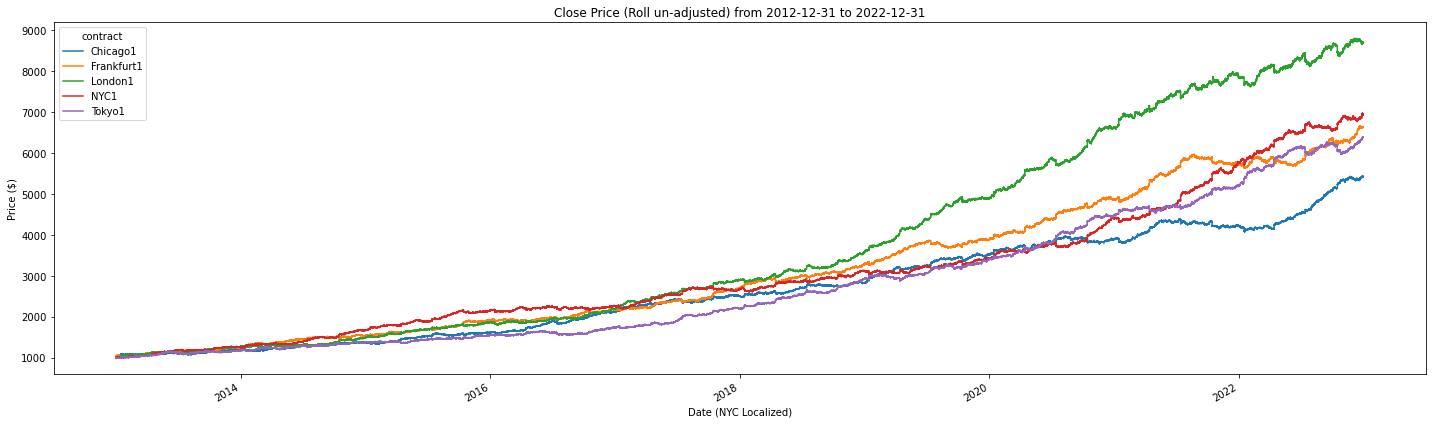

In [41]:
def plot_price(df_price: pd.DataFrame):

    (df_price[
        ["contract_name", "nyc_time", "close_price"]].
        rename(columns = {"contract_name": "contract"}).
        pivot(index = "nyc_time", columns = "contract", values = "close_price").
        fillna(method = "bfill").
        fillna(method = "ffill").
        plot(
            figsize = (20,6),
            ylabel = "Price ($)",
            xlabel = "Date (NYC Localized)",
            title = "Close Price (Roll un-adjusted) from {} to {}".format(
                df_price.nyc_time.min().date(),
                df_price.nyc_time.max().date())))

    plt.tight_layout()
    plt.show()
    
plot_price(df_price)

Simply plot the data and account for the various contracts as they get rolled. In this case use close as the price. Due to the computational strain of plotting 5 min bars for 10yrs the data will be resampled with the first price of each day

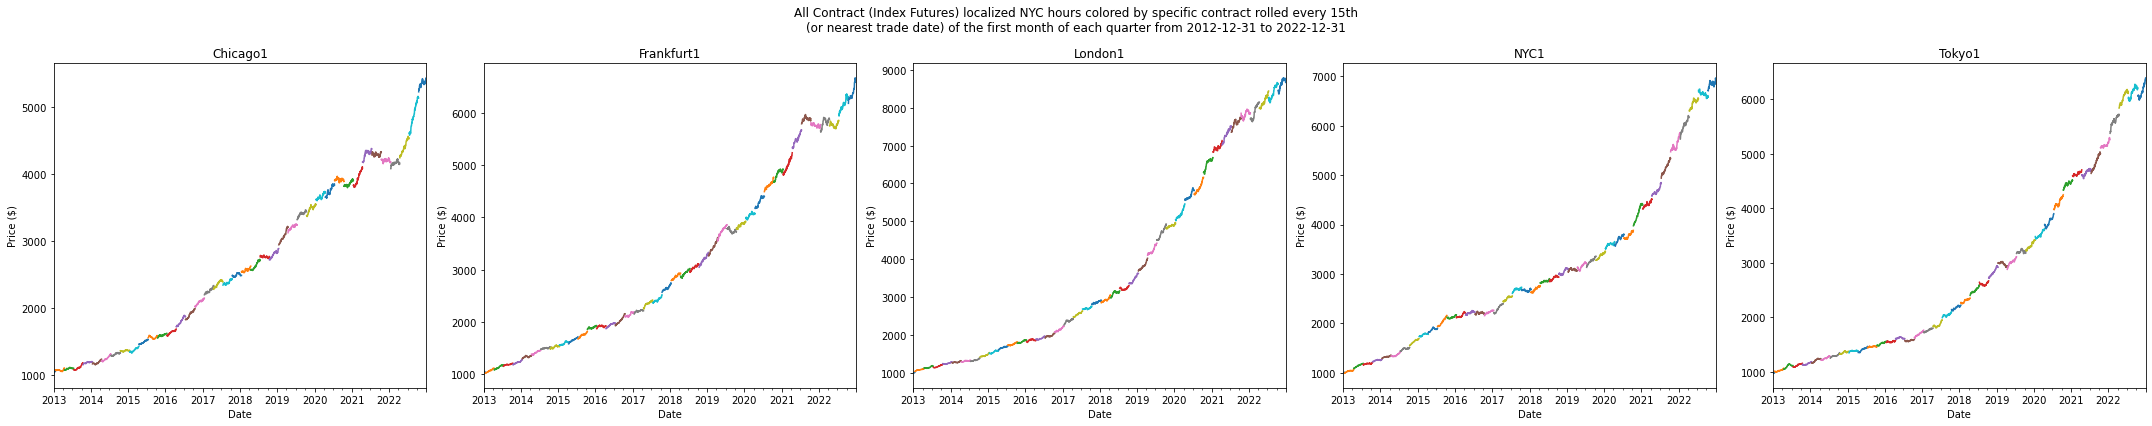

In [7]:
def plot_close_with_roll(df_price: pd.DataFrame):

    contract_names = df_price.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contract_names), figsize = (30,6))

    for i, contract_name in enumerate(contract_names):

        df_tmp = (df_price.query(
            "contract_name == @contract_name").
            set_index("nyc_time").
            resample("D").
            first())

        contracts = df_tmp.contract.drop_duplicates().to_list()
        for contract in contracts:

            (df_tmp.query(
                "contract == @contract")
                [["close_price"]].
                plot(
                    ax = axes[i],
                    legend = False,
                    title = "{}".format(contract_name),
                    xlabel = "Date",
                    ylabel = "Price ($)"))

    fig.suptitle("All Contract (Index Futures) localized NYC hours colored by specific contract rolled every 15th\n(or nearest trade date) of the first month of each quarter from {} to {}".format(
        df_price.nyc_time.min().date(),
        df_price.nyc_time.max().date()))
    plt.tight_layout()
    plt.show()

plot_close_with_roll(df_price)

Make bars

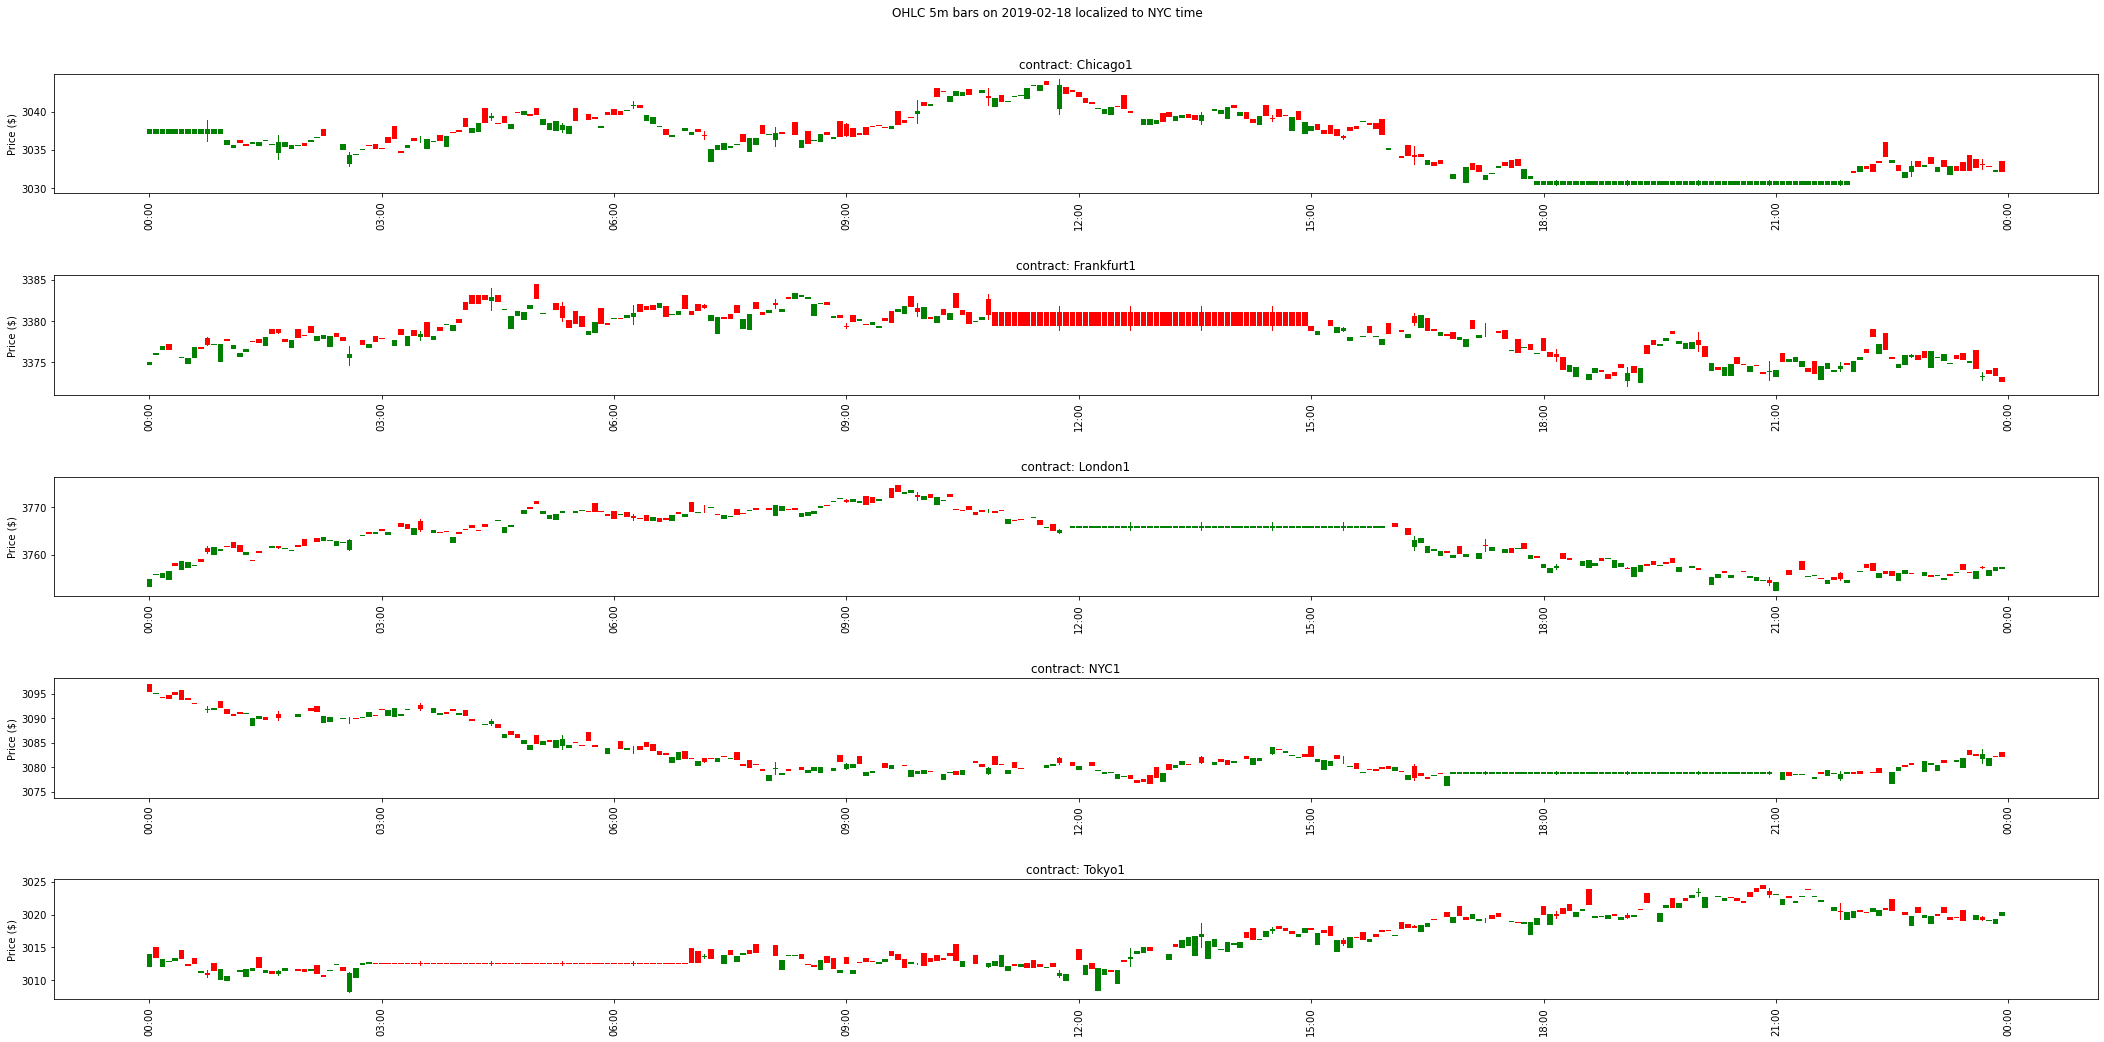

In [94]:
def make_ohlc_bars(df_price: pd.DataFrame, date):

    df_tmp = (df_price.assign(
        date = lambda x: x.nyc_time.dt.date).
        query("date == @rand_date"))

    df_contract = (df_tmp.set_index(
        "nyc_time")
        [["contract_name", "open_price", "high_price", "low_price", "close_price"]])

    contracts = df_contract.contract_name.drop_duplicates().to_list()

    fig, axes = plt.subplots(nrows = len(contracts), figsize = (30,15))
    for i, contract in enumerate(contracts):

        df_plot = (df_contract.query(
            "contract_name == @contract").
            drop(columns = ["contract_name"]))

        df_up = df_plot.query("close_price > open_price")
        df_down = df_plot.query("close_price < open_price")

        width1 = 0.003
        width2 = 0.00003

        axes[i].bar(df_up.index, df_up.close_price - df_up.open_price, width1, bottom = df_up.open_price, color = "red")
        axes[i].bar(df_up.index, df_up.high_price - df_up.close_price, width2, bottom = df_up.close_price, color = "red") 
        axes[i].bar(df_up.index, df_up.low_price - df_up.open_price, width2, bottom = df_up.open_price, color = "red") 

        axes[i].bar(df_down.index, df_down.close_price - df_down.open_price, width1, bottom = df_down.open_price, color = "green")
        axes[i].bar(df_down.index, df_down.high_price - df_down.open_price, width2, bottom = df_down.open_price, color = "green") 
        axes[i].bar(df_down.index, df_down.low_price - df_down.close_price, width2, bottom = df_down.close_price, color = "green") 

        axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        axes[i].tick_params(axis = "x", rotation = 90)
        axes[i].set_title("contract: {}".format(contract))
        axes[i].set_ylabel("Price ($)")

    fig.suptitle("OHLC 5m bars on {} localized to NYC time".format(rand_date))
    plt.tight_layout(pad = 3)

make_ohlc_bars(df_price, rand_date)

# Calculations

## Rolling Adjusted Close

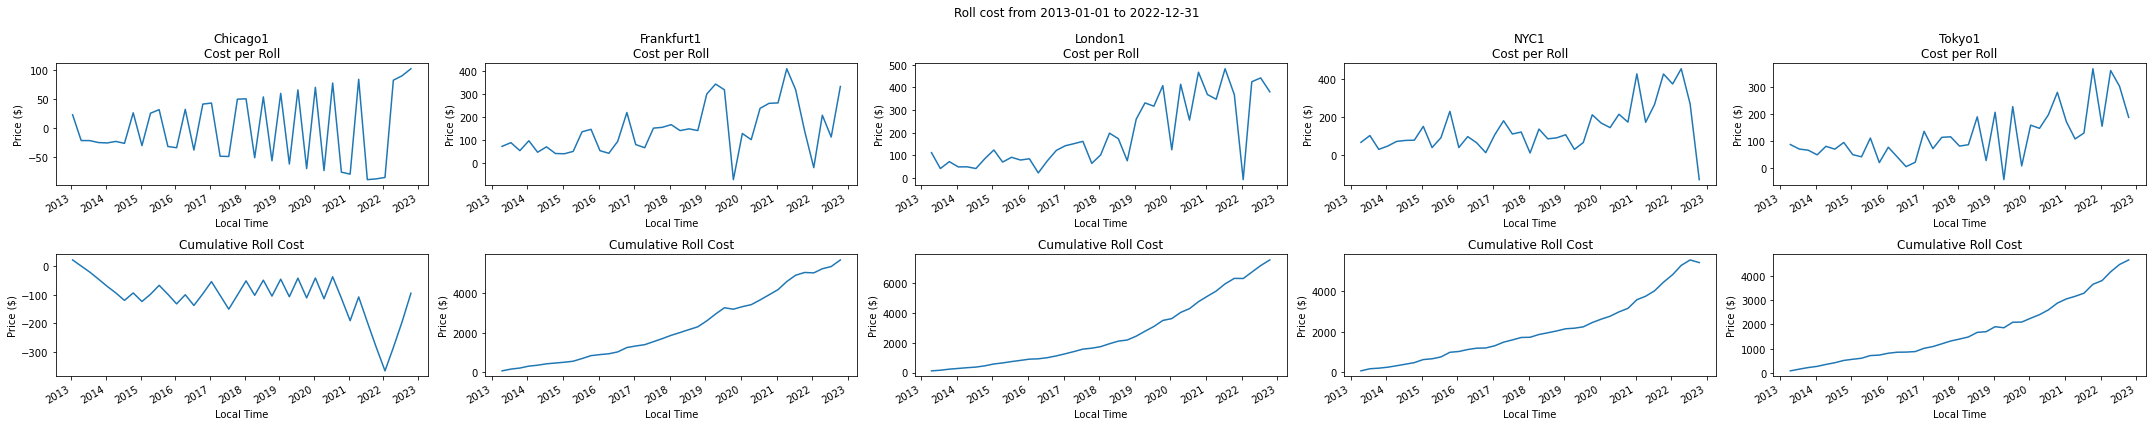

In [117]:
def _get_first_last(df: pd.DataFrame) -> pd.DataFrame: 
    return(df.query(
        "local_time == local_time.min() | local_time == local_time.max()").
        assign(
            place = ["first", "last"],
            contract = lambda x: x.contract.astype(int)))

def _calc_roll_cost(df: pd.DataFrame) -> pd.DataFrame:
    
    cost = df.close_price.diff().to_list()[1]
    date = df.local_time.max()
    df_out = (pd.DataFrame({
        "cost": [cost],
        "local_time": [date]}))
    
    return df_out

def _get_roll_cost(df: pd.DataFrame) -> pd.DataFrame:
    
    # get first and last price of each contract
    df_first_last = (df.assign(
        contract = lambda x: x.contract.str.split("_").str[1]).
        groupby(["contract"]).
        apply(_get_first_last).
        reset_index(drop = True).
        sort_values("contract"))
    
    # then drop the first value of the first contract since it wasn't rolled into
    first_contract = df_first_last.contract.min()
    df_first_last_shifted = (df_first_last.query(
        "contract != contract.min() | place != 'first'").
        sort_values("local_time"))
    
    last_spot = df_first_last_shifted.query("contract == contract.max()").tail(1).place.iloc[0]
    
    # we can slice out the last spot if it isn't rolled into
    if last_spot == "last": df_first_last_shifted = df_first_last_shifted.iloc[:-1]
    
    df_grouped = (df_first_last_shifted.assign(
        group = np.repeat(range(1, int(len(df_first_last_shifted) / 2) + 1), 2)).
        groupby(["group"]).
        apply(_calc_roll_cost).
        set_index("local_time").
        assign(cum_cost = lambda x: np.cumsum(x.cost)))

    return df_grouped

def get_roll_cost(df_price: pd.DataFrame) -> pd.DataFrame:

    df_out = (df_price[
        ["local_time", "contract", "close_price", "contract_name"]].
        groupby("contract_name").
        apply(_get_roll_cost).
        reset_index())
    
    return df_out

def plot_roll_cost(df_price: pd.DataFrame, figsize: tuple = (30, 6)) -> pd.DataFrame:
    
    df_roll_cost = get_roll_cost(df_price)
    contract_names = df_roll_cost.contract_name.drop_duplicates().to_list()

    fig, axes = plt.subplots(ncols = len(contract_names), nrows = 2, figsize = figsize)
    for i, contract in enumerate(contract_names):

        df_tmp = (df_roll_cost.query(
            "contract_name == @contract").
            drop(columns = ["contract_name"]).
            rename(columns = {"local_time": "Local Time"}).
            set_index("Local Time"))

        (df_tmp["cost"].plot(
            ax = axes[0,i],
            title = "{}\nCost per Roll".format(contract),
            ylabel = "Price ($)"))

        (df_tmp["cum_cost"].plot(
            ax = axes[1,i],
            ylabel = "Price ($)",
            title = "Cumulative Roll Cost"))
        
    fig.suptitle("Roll cost from {} to {}".format(
        df_price.local_time.min().date(),
        df_price.local_time.max().date()))

    plt.tight_layout()
    
df_roll_cost = get_roll_cost(df_price)
plot_roll_cost(df_price)

In [158]:
df_test = (df_price.merge(
    right = df_roll_cost.drop(columns = ["cost"]), 
    how = "outer", 
    on = ["contract_name", "local_time"]).
    sort_values(["contract_name", "local_time"]).
    fillna(method = "ffill")
    [["contract_name", "close_price", "cum_cost", "nyc_time"]].
    assign(close_roll_adj = lambda x: x.close_price - x.cum_cost.fillna(0)))

<AxesSubplot:xlabel='nyc_time'>

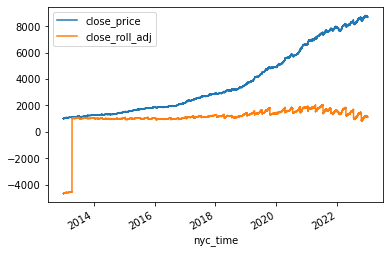

In [161]:
(df_test.query(
    "contract_name == 'London1'").
    set_index("nyc_time")
    [["close_price", "close_roll_adj"]].
    plot())